In [8]:
!pip install prophet

   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
    --------------------------------------- 0.3/12.1 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.1 MB 4.2 MB/s eta 0:00:03
   ----- ---------------------------------- 1.6/12.1 MB 3.4 MB/s eta 0:00:04
   ------ --------------------------------- 1.8/12.1 MB 2.5 MB/s eta 0:00:05
   ------ --------------------------------- 2.1/12.1 MB 2.3 MB/s eta 0:00:05
   ------------ --------------------------- 3.7/12.1 MB 3.2 MB/s eta 0:00:03
   -------------- ------------------------- 4.5/12.1 MB 3.4 MB/s eta 0:00:03
   ----------------- ---------------------- 5.2/12.1 MB 3.4 MB/s eta 0:00:03
   ------------------ --------------------- 5.5/12.1 MB 3.4 MB/s eta 0:00:02
   -------------------- ------------------- 6.3/12.1 MB 3.1 MB/s eta 0:00:02
   --------------------- ------------------ 6.6/12.1 MB 3.1 MB/s eta 0:00:02
   ------------------------ --------------- 7.3/12.1 MB 3.0 MB/s eta 0:00:02
   ----------

In [4]:
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/72.0 MB 2.8 MB/s eta 0:00:26
   - -------------------------------------- 2.1/72.0 MB 5.9 MB/s eta 0:00:12
   -- ------------------------------------- 3.7/72.0 MB 6.4 MB/s eta 0:00:11
   -- ------------------------------------- 4.5/72.0 MB 5.7 MB/s eta 0:00:12
   -- ------------------------------------- 4.7/72.0 MB 5.4 MB/s eta 0:00:13
   --- ------------------------------------ 5.5/72.0 MB 4.4 MB/s eta 0:00:16
   --- ------------------------------------ 5.8/72.0 MB 4.1 MB/s eta 0:00:17
   --- ------------------------------------ 6.3/72.0 MB 3.8 MB/s eta 0:00:18
   --- ------------------------------------ 6.6/72.0 MB 3.7 MB/s eta 0:00:18
   --- ------------------------------------ 6.8/72.0 MB 3.5 MB/s eta 0:00:19
   ---- ----------------------------------- 7.3/72.0 MB 3.1 MB/s eta 0:00:21
   ---- ----------------------------------- 7.6/72.0 MB 3.0 MB/s eta 0:00:22
   ---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
# ==========================================
# 1. Load and Preprocess Data
# ==========================================
print("--- Loading Data ---")
# <--- CHANGE THIS: Your file name
df = pd.read_csv('household_power_consumption.csv') 
df.head()



--- Loading Data ---


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17.0
1,16/12/2006,17:25:00,5.36,0.436,233.63,23,0,1,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17.0


Data Loaded & Cleaned. Total Days: 728
Training on 668 days, Testing on 60 days.

--- Running ARIMA Model ---
--- Running Prophet Model ---


C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hp\anac

--- Running XGBoost Model ---

--- Performance (RMSE) ---
ARIMA:   0.4370
Prophet: 0.3604
XGBoost: 0.3467


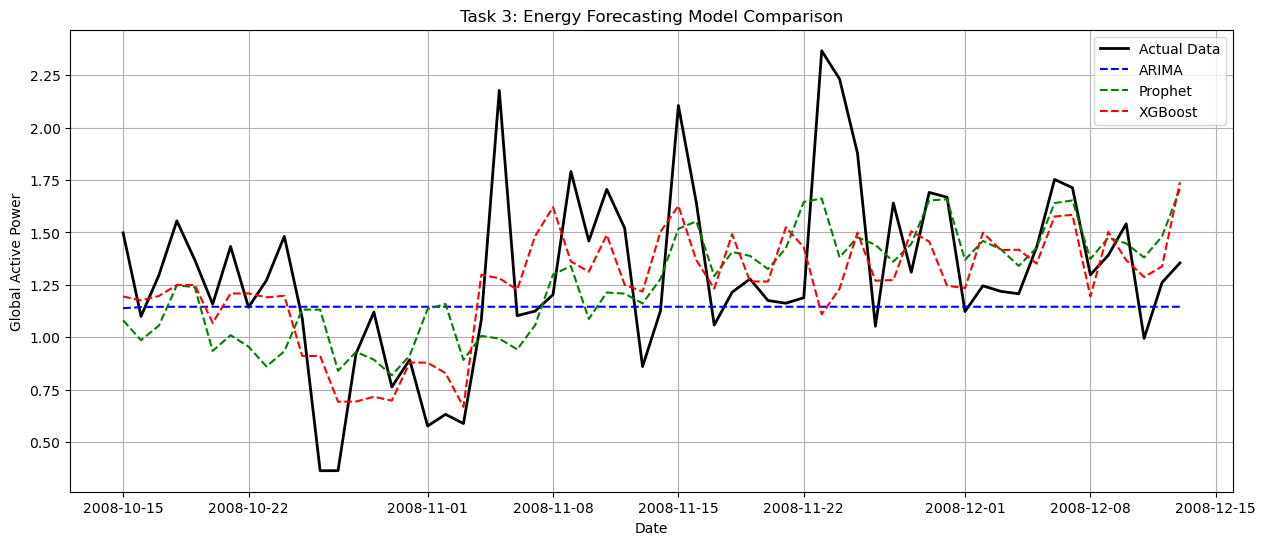

In [3]:
# Clean columns
df.columns = [col.strip() for col in df.columns]

# Parse Date and Time
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors='coerce')
df.set_index('Datetime', inplace=True)

# Numeric conversion
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Drop initial missing values
df.dropna(subset=['Global_active_power'], inplace=True)

# RESAMPLE to Daily
# Note: Resampling can sometimes create new NaNs if a whole day is missing
df_daily = df['Global_active_power'].resample('D').mean().to_frame()

# *** CRITICAL FIX: Drop NaNs again after resampling ***
df_daily.dropna(inplace=True)

print(f"Data Loaded & Cleaned. Total Days: {len(df_daily)}")

# ==========================================
# 2. Split Data
# ==========================================
test_days = 60
train_data = df_daily.iloc[:-test_days]
test_data = df_daily.iloc[-test_days:]

print(f"Training on {len(train_data)} days, Testing on {len(test_data)} days.")

# ==========================================
# 3. Model 1: ARIMA
# ==========================================
print("\n--- Running ARIMA Model ---")
# Using a simpler order (1,1,1) which is more robust to errors
try:
    arima_model = ARIMA(train_data['Global_active_power'], order=(1,1,1))
    arima_fit = arima_model.fit()
    arima_pred = arima_fit.forecast(steps=len(test_data))
except Exception as e:
    print(f"ARIMA Error: {e}")
    arima_pred = np.zeros(len(test_data))

# ==========================================
# 4. Model 2: Prophet
# ==========================================
print("--- Running Prophet Model ---")
try:
    df_prophet = train_data.reset_index().rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'})
    model_prophet = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
    model_prophet.fit(df_prophet)
    
    future = model_prophet.make_future_dataframe(periods=len(test_data))
    forecast = model_prophet.predict(future)
    prophet_pred = forecast['yhat'].tail(len(test_data)).values
except Exception as e:
    print(f"Prophet Error: {e}")
    prophet_pred = np.zeros(len(test_data))

# ==========================================
# 5. Model 3: XGBoost (Fixing the Error)
# ==========================================
print("--- Running XGBoost Model ---")

def create_features(data):
    df_feat = data.copy()
    df_feat['dayofweek'] = df_feat.index.dayofweek
    df_feat['quarter'] = df_feat.index.quarter
    df_feat['month'] = df_feat.index.month
    df_feat['year'] = df_feat.index.year
    df_feat['dayofyear'] = df_feat.index.dayofyear
    return df_feat

# Create features
X_train = create_features(train_data).drop(columns=['Global_active_power'])
y_train = train_data['Global_active_power']
X_test = create_features(test_data).drop(columns=['Global_active_power'])
y_test = test_data['Global_active_power']

# *** SAFETY CHECK: Ensure no NaNs in Y (Target) ***
# This specifically fixes the "Label contains NaN" error
if y_train.isnull().any() or y_test.isnull().any():
    print("Found NaNs in target variable. Dropping them...")
    # Align X and y by dropping missing values
    train_clean = pd.concat([X_train, y_train], axis=1).dropna()
    test_clean = pd.concat([X_test, y_test], axis=1).dropna()
    
    X_train = train_clean.drop(columns=['Global_active_power'])
    y_train = train_clean['Global_active_power']
    X_test = test_clean.drop(columns=['Global_active_power'])
    y_test = test_clean['Global_active_power']

# Train XGBoost
model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01, early_stopping_rounds=50)
model_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

xgb_pred = model_xgb.predict(X_test)

# ==========================================
# 6. Evaluation & Visualization
# ==========================================
# Only calculate RMSE if prediction length matches (which it should now)
rmse_arima = np.sqrt(mean_squared_error(test_data, arima_pred))
rmse_prophet = np.sqrt(mean_squared_error(test_data, prophet_pred))
rmse_xgb = np.sqrt(mean_squared_error(test_data.iloc[:len(xgb_pred)], xgb_pred))

print(f"\n--- Performance (RMSE) ---")
print(f"ARIMA:   {rmse_arima:.4f}")
print(f"Prophet: {rmse_prophet:.4f}")
print(f"XGBoost: {rmse_xgb:.4f}")

plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data['Global_active_power'], label='Actual Data', color='black', linewidth=2)
plt.plot(test_data.index, arima_pred, label='ARIMA', linestyle='--', color='blue')
plt.plot(test_data.index, prophet_pred, label='Prophet', linestyle='--', color='green')
plt.plot(test_data.index[:len(xgb_pred)], xgb_pred, label='XGBoost', linestyle='--', color='red')

plt.title('Task 3: Energy Forecasting Model Comparison')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.grid(True)
plt.show()